In [1]:
setwd("C:/Users/User/Documents")
source("Meus Arquivos/Códigos/Arima.R")

In [2]:
pacotes <- c("tidyverse","rbcb","forecast","ggthemes","vars","lubridate")
for(i in pacotes){
    suppressPackageStartupMessages(library(i, character.only = T))
}

Warning message:
"package 'vars' was built under R version 4.0.3"
Warning message:
"package 'strucchange' was built under R version 4.0.3"
Warning message:
"package 'sandwich' was built under R version 4.0.3"


In [3]:
#Série temporal do BCB do IPCA
inicio <- as.Date("1996-01-01")
inf <- get_series(c(IPCA = 433), as = "ts", start_date = inicio)
year <- lubridate::year(inicio)
month <- lubridate::month(inicio)
#Monta as matrizes para colocar os dados das previsões
fore <- matrix(0, nrow = length(inf)-25)
fore_s <- matrix(0, nrow = length(inf)-25)
fore_i <- matrix(0, nrow = length(inf)-25)

In [4]:
#Loop gerador das previsões de 1 período
for(i in 25:length(inf)){
  inf_ar <- Arima(ts(inf[1:i], start = c(year,month), frequency = 12),
                  seasonal = c(1,0,0), order = c(1,0,0))
  forec <- forecast(inf_ar, h = 1)
  fore[i-24] <- forec$mean
  fore_s[i-24] <- forec$upper[,2]
  fore_i[i-24] <- forec$lower[,2]
}

In [5]:
#Armazena os dados das previsões
data <- data.frame(Data = seq(inicio+2*365, as.Date("2020-10-01"),"1 month"),
                   Mean = fore,
                   Upper = fore_s,
                   Lower = fore_i,
                   Real = inf[25:length(inf)])

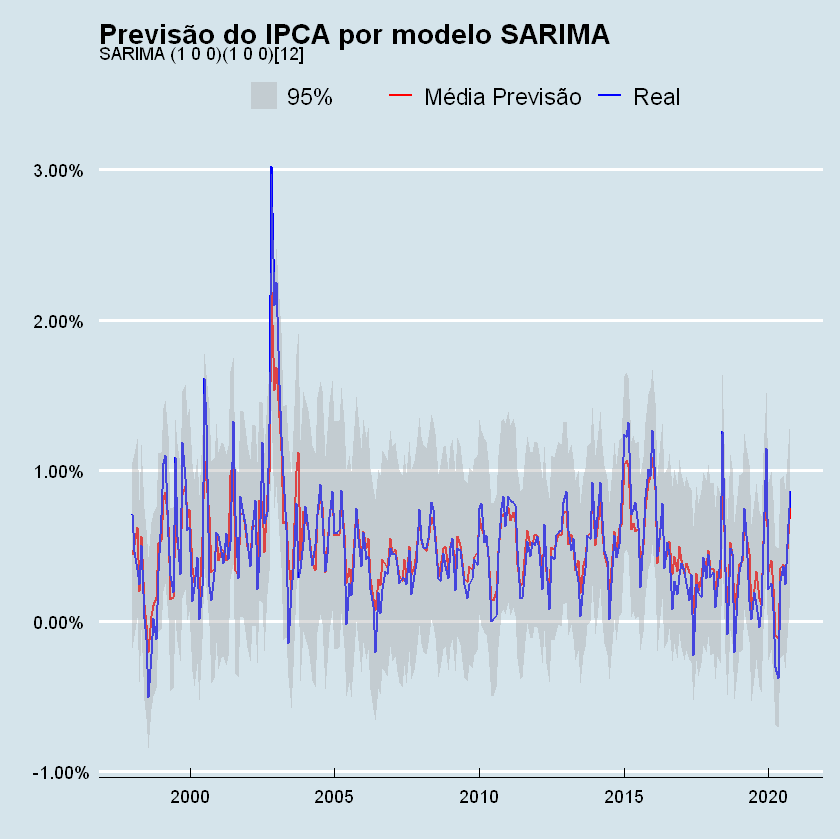

In [6]:
#Plota o gráfico
data %>%
  ggplot(aes(x = Data))+
  geom_line(aes(y = Mean/100, col = "Média Previsão"), size = 0.7)+
  geom_line(aes(y = Real/100, col = "Real"), size = 0.7)+
  geom_ribbon(aes(ymin = Lower/100, ymax = Upper/100, fill = "95%"), alpha = 0.4)+
  scale_colour_manual("", values = c("red","blue"))+
  theme_economist()+
  scale_y_continuous(labels = scales::percent)+
  labs(x = "", y = "", title = "Previsão do IPCA por modelo SARIMA",
       subtitle = "SARIMA (1 0 0)(1 0 0)[12]")+
  scale_fill_manual("",values = "darkgrey")

In [7]:
tail(data,1)

,Data,Mean,Upper,Lower,Real
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
274,2020-10-01,0.7793821,1.373608,0.185156,0.86


In [10]:
#Combinando modelos#

#Coletando e tratando os dados
ipca <- get_series(c(IPCA = 433), start_date = "2000-01-01") %>% #IPCA
  mutate(ano = year(date),mes = month(date))
dolar <- get_series(c(Dólar = 1), start_date = "2000-01-01") %>% #Dólar
  mutate(ano = year(date),mes = month(date)) %>%
  group_by(ano, mes) %>%
  summarise(Dólar = first(Dólar))
desemprego <- get_series(c(Desemprego = 24369)) %>% #Desemprego
  mutate(ano = year(date),mes = month(date))

`summarise()` regrouping output by 'ano' (override with `.groups` argument)



In [11]:
#Série com desemprego
tot <- left_join(desemprego, dolar, by = c("ano" = "ano", "mes" = "mes"))
tot <- left_join(tot,ipca, by = c("ano" = "ano", "mes" = "mes"))
ano <- xts::last(tot$ano)
mes <- xts::last(tot$mes)
tot <- tot %>%
  summarise(date = date.x, Desemprego = Desemprego/100, Dólar, IPCA = IPCA/100)
tot$Dólar <- c(0,diff(tot$Dólar)) #Variação Dólar 
tot$Desemprego <- c(0,diff(tot$Desemprego)) #Variação Desemprego
tot_ts <- ts(tot[,-1], end = c(ano,mes), frequency = 12) #Série temporal

In [12]:
#Série sem desemprego
tot1 <- left_join(ipca,dolar, by = c("ano","mes")) %>%
  summarise(date, IPCA = IPCA/100, Dólar = c(0,diff(Dólar)/Dólar[2:length(Dólar)-1]))
ano_ipc <- xts::last(year(tot1$date))
mes_ipc <- xts::last(month(tot1$date))
tot1_ts <- ts(tot1[,-1], end = c(ano_ipc,mes_ipc),frequency = 12)

In [13]:
#Modelo Sarima
ipca_ts <- ts(tot1$IPCA,end = c(ano,mes), frequency = 12)
bic <- auto.arima(ipca_ts, stationary = T)

In [14]:
#Modelo VAR
dummies <- seasonaldummy(ipca_ts)
var <- VAR(tot1_ts, type = "both", exogen = dummies)

In [15]:
#Redes neurais
neural <- nnetar(ipca_ts)

In [16]:
#Previsões
n_forecast <- 5
fore_bic <- forecast(bic, h = n_forecast)
fore_neural <- forecast(neural, h = n_forecast, PI = T)
fore_var <- predict(var, n.ahead = n_forecast,
                    dumvar = head(dummies,n_forecast))

In [45]:
#Pesos dos modelos
erro_bic <- accuracy(bic)[2]^2
erro_neural <- accuracy(neural)[2]^2
erro_var <- sum(var$varresult$IPCA$residuals^2)/nrow(tot_ts)
peso_ar <- (1/erro_bic)/(1/erro_bic+1/erro_neural+1/erro_var)
peso_neural <- (1/erro_neural)/(1/erro_bic+1/erro_neural+1/erro_var)
peso_var <- (1/erro_var)/(1/erro_bic+1/erro_neural+1/erro_var)
peso_ar
peso_neural
peso_var
fitted <- peso_ar*bic$fitted+peso_neural*neural$fitted+
  peso_var*var$varresult$IPCA$fitted.values
erro <- sum((fitted-ipca_ts)^2, na.rm = T)/length(ipca_ts)

[1] 0.3897329

[1] 0.4341705

[1] 0.1760966

Warning message in `+.default`(peso_ar * bic$fitted + peso_neural * neural$fitted, :
"comprimento do objeto maior não é múltiplo do comprimento do objeto menor"


In [46]:
names(erro_bic) <- "Erro ARIMA"
names(erro_neural) <- "Erro Neural"
names(erro_var) <- "Erro VAR"
names(erro) <- "Erro combinado"
erro_bic
erro_neural
erro_var
erro

Erro ARIMA 
8.418775e-06

Erro Neural 
7.557108e-06

Erro VAR 
1.863224e-05

Erro combinado 
  5.674945e-06

Warning message:
"Removed 12 row(s) containing missing values (geom_path)."


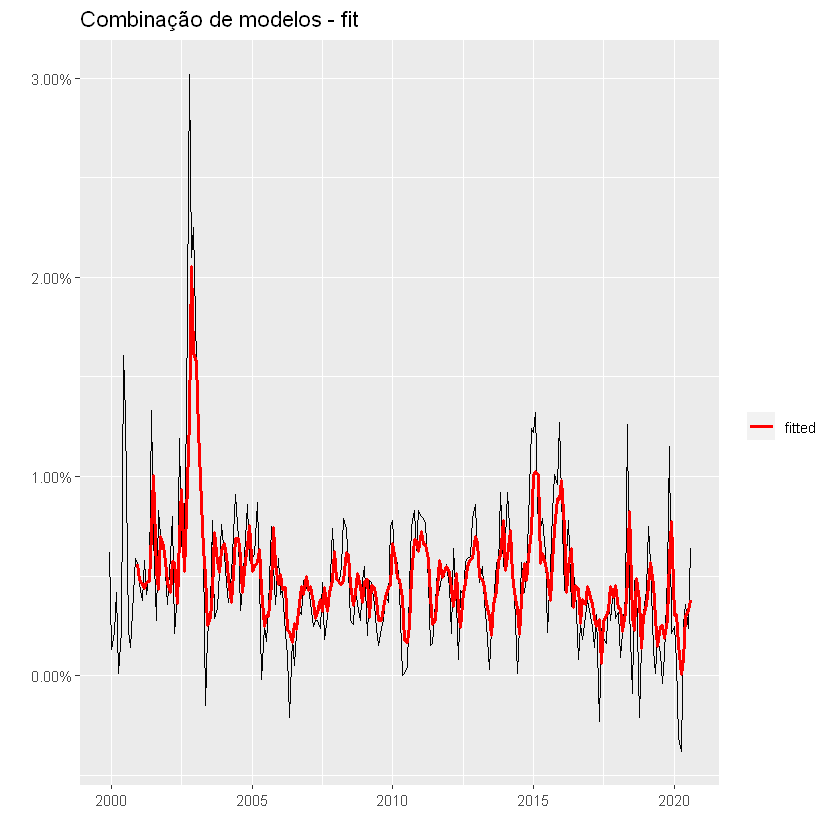

In [55]:
autoplot(ipca_ts)+
    autolayer(fitted, size = 1)+
    scale_y_continuous(labels = scales::percent)+
    labs(x = "", y = "", title = "Combinação de modelos - fit")+
    scale_color_manual("", values = "red")

In [48]:
peso_ar+peso_neural+peso_var

[1] 1

In [49]:
fore_mean <- fore_bic$mean*peso_ar+
  fore_neural$mean*peso_neural+
  fore_var$fcst$IPCA[,1]*peso_var
fore_upper <- fore_neural$upper[,2]*peso_neural+
  fore_var$fcst$IPCA[,3]*peso_var+
  fore_bic$upper[,2]*peso_ar
fore_lower <- fore_neural$lower[,2]*peso_neural+
  fore_var$fcst$IPCA[,4]*peso_var+
  fore_bic$lower[,2]*peso_ar
fore_tot <- cbind(fore_lower,fore_mean,fore_upper)
fore_tot

,fore_lower,fore_mean,fore_upper
Sep 2020,0.0010014536,0.005653187,0.01127090
Oct 2020,-0.0001295359,0.005027984,0.01186080
Nov 2020,0.0005038225,0.005611050,0.01282560
Dec 2020,-0.0001239962,0.004808668,0.01195017
Jan 2021,-0.0002220869,0.004339758,0.01152783


For a multivariate timeseries, specify a seriesname for each timeseries. Defaulting to column names.



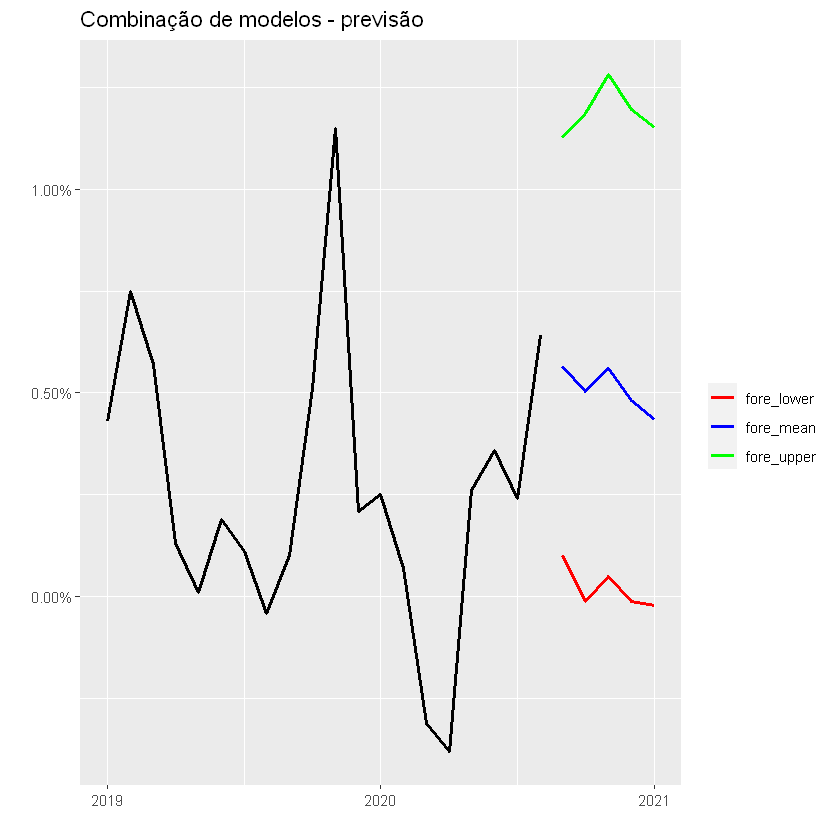

In [51]:
media_var <- ts(fore_var$fcst$IPCA[,1], start = c(ano,mes+1), frequency = 12)
autoplot(tail(ipca_ts,20), size = 1)+
    autolayer(fore_tot, size = 1)+
    scale_color_manual("",values = c("red","blue","green"))+
    scale_y_continuous(labels = scales::percent)+
    labs(x = "", y = "", title = "Combinação de modelos - previsão")

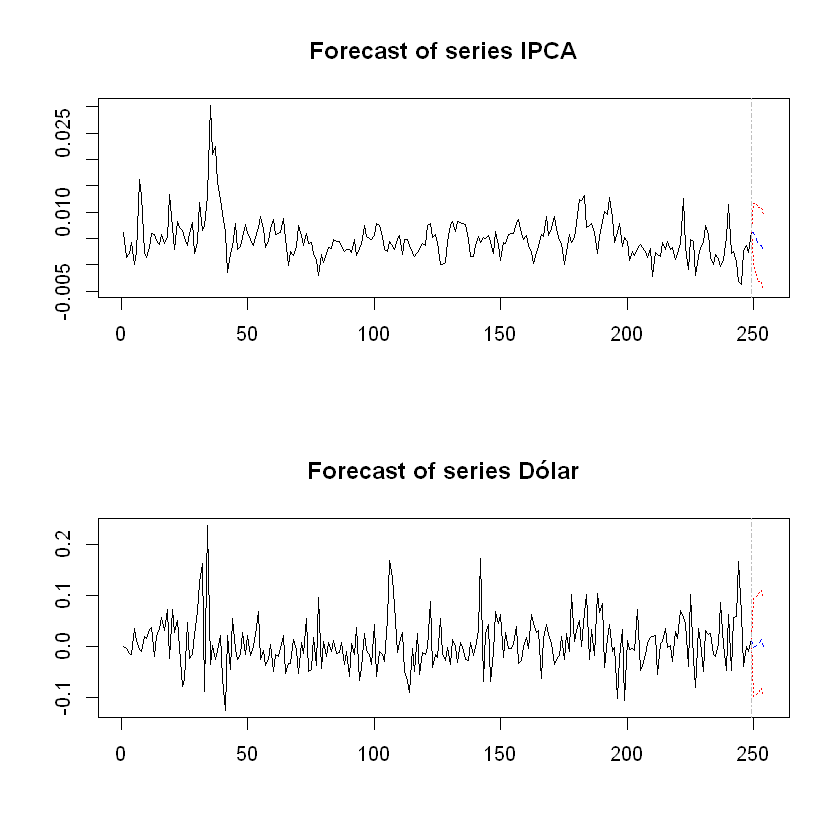

In [24]:
plot(fore_var)

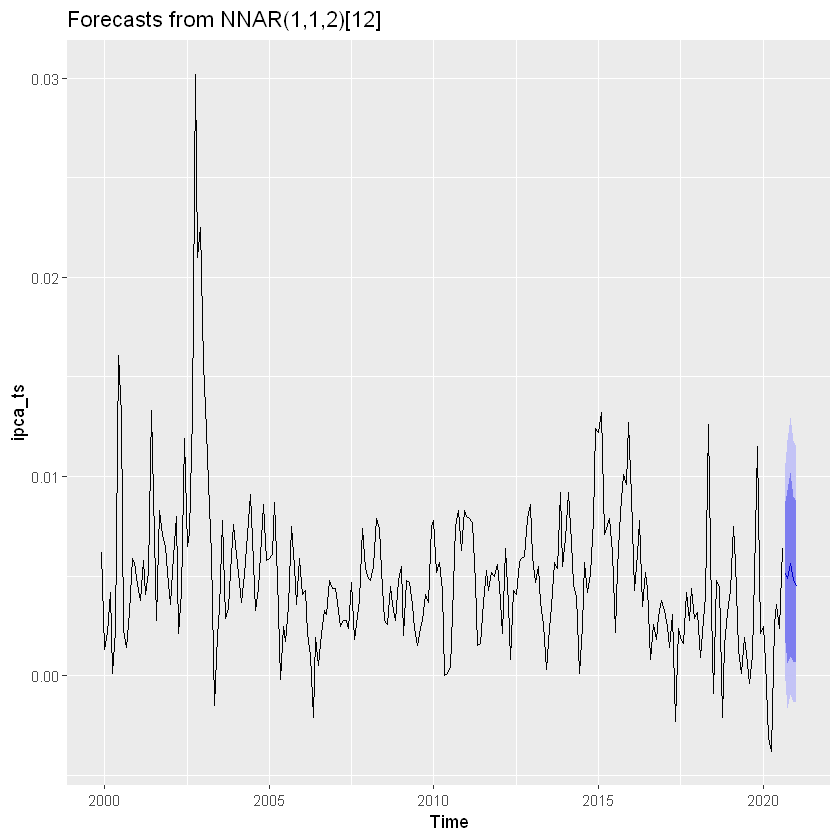

In [25]:
autoplot(fore_neural)

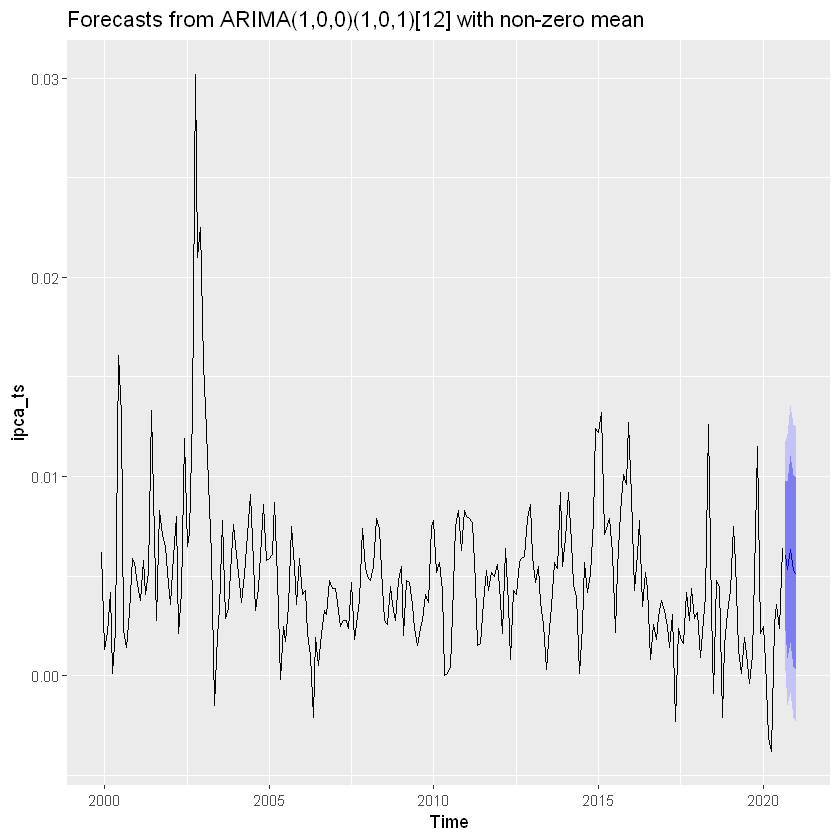

In [26]:
autoplot(fore_bic)